# ORIE 4741 Project
### Netflix Success Predictor

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import RocCurveDisplay, recall_score, precision_score, roc_curve, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [19]:
netflix=pd.read_csv('datasets/netflix.csv')

In [20]:
netflix.head()

,show_title,type,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,language,is_staggered_launch,available_globally,release_date,genre,main_production,week
0,'83,Films,6825000.0,NaN,2,NaN,NaN,Non-English,False,No,NaN,NaN,NaN,2022-04-03
1,10 Days of a Bad Man,Films,6900000.0,3300000.0,2,2.0667,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-08-27
2,10 Days of a Good Man,Films,7415000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-03-12
3,1000 Miles from Christmas,Films,6795000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2022-01-02
4,12 Strong,Films,8210000.0,NaN,2,NaN,NaN,English,False,No,NaN,NaN,NaN,2022-07-24


## Feature Engineering
Before we create a model in order to understand the features of importance for Netflix streaming content success and use it to predict how many views a show/film gets, we need to inspect the data and utilize feature engineering tools. 

#### Dealing with simple NaN values: 

In [21]:
def size_if_na_dropped(df):
  print(f"Out of {df.shape[0]} total points, if we drop all with missing data, \
we'll have {df.dropna().shape[0]} points (or {df.dropna().shape[0]/df.shape[0]} \
  of the original dataset)")

size_if_na_dropped(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


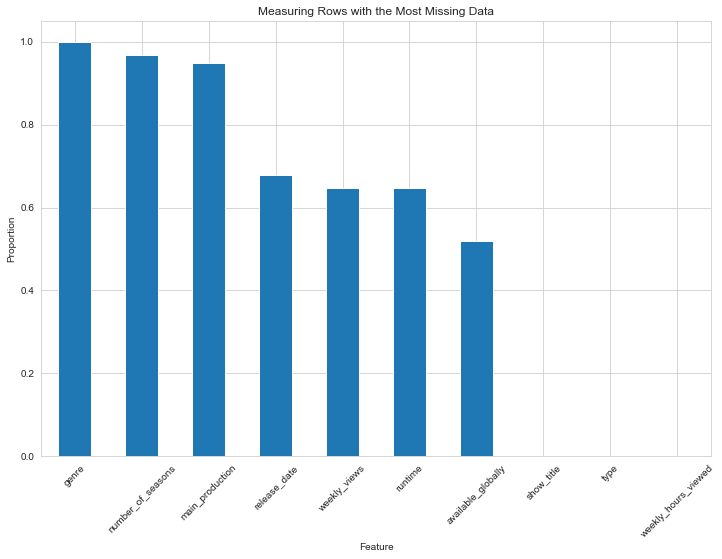

In [22]:
def plot_na(df):
  sns.set_style('whitegrid')
  plt.figure(figsize=(12,8))
  missing_vals = df.isna().sum()/df.shape[0]
  missing_vals = missing_vals.sort_values(ascending=False)[0:10]
  ax = missing_vals.plot(kind='bar')

  ax.set_title('Measuring Rows with the Most Missing Data')
  ax.set_ylabel('Proportion')
  ax.set_xlabel('Feature')
  ax.tick_params(axis='x', rotation=45)

plot_na(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


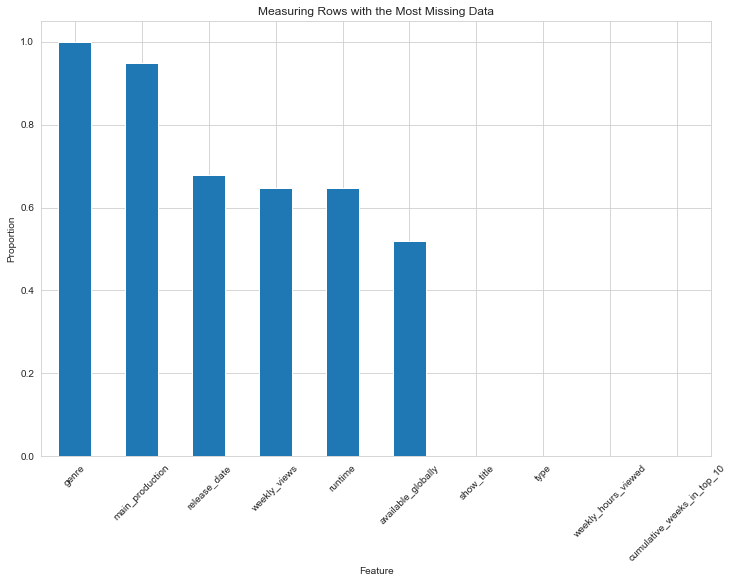

In [23]:
#The NaN values of number_of_seasons occur b/c they are films not shows, impute with 0
netflix['number_of_seasons'] = netflix['number_of_seasons'].fillna(0)
plot_na(netflix)
size_if_na_dropped(netflix)

#### Dealing with Categorical Values
There are a few categorical features in our data. To deal with them we will do the following
- One hot encoding the binary values: Language, Type, Available Globally
- Multi-hot encoding genre list

In [24]:
encoded_df= pd.get_dummies(netflix[['language','type','is_staggered_launch','available_globally' ]])
netflix = pd.concat([netflix.drop(columns=['language','type','is_staggered_launch','available_globally' ]), encoded_df], axis=1)
netflix

,show_title,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,release_date,genre,main_production,week,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,'83,6.825000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-04-03,False,0,1,1,0,1,0
1,10 Days of a Bad Man,6.900000e+06,3300000.0,2,2.0667,0.0,NaN,NaN,NaN,2023-08-27,False,0,1,1,0,0,0
2,10 Days of a Good Man,7.415000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2023-03-12,False,0,1,1,0,0,0
3,1000 Miles from Christmas,6.795000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-01-02,False,0,1,1,0,0,0
4,12 Strong,8.210000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-07-24,False,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,2.400000e+06,1300000.0,1,1.8500,0.0,NaN,NaN,NaN,2024-01-21,False,0,1,1,0,0,0
1861,¡Que viva México!,1.249250e+07,NaN,4,NaN,0.0,2023-05-11,NaN,NaN,2023-06-04,False,0,1,1,0,0,1
1862,Ìjọ̀gbọ̀n,4.950000e+06,2550000.0,2,1.9333,0.0,NaN,NaN,NaN,2023-10-22,False,0,1,1,0,0,0
1863,أصحاب ...ولا أعزّ,2.910000e+06,NaN,3,NaN,0.0,2022-01-20,NaN,NaN,2022-02-06,False,0,1,1,0,1,0


#### Dealing with Missing Data


In [25]:
from numpy.linalg import svd

In [26]:
netflix_fill=netflix.copy()

In [27]:
#Imputing runtime values based on content type
meanfilm=netflix[netflix['type_Films']==1]['runtime'].mean()
netflix_fill.loc[netflix_fill['type_Films'] == 1, 'runtime'] = netflix.loc[netflix['type_Films'] == 1, 'runtime'].fillna(meanfilm)
meantv=netflix[netflix['type_Films']==0]['runtime'].mean()
netflix_fill.loc[netflix_fill['type_Films'] == 0, 'runtime'] = netflix.loc[netflix['type_Films'] == 0, 'runtime'].fillna(meantv)

#Imputing availably globally
netflix_fill['available_globally_Yes'] = netflix_fill.apply(lambda row: True if row['language_Non-English'] == True else row['available_globally_Yes'], axis=1)

In [28]:
netflix_np=netflix_fill[['weekly_views',
       'cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons',
       'is_staggered_launch', 'language_English', 'language_Non-English',
       'type_Films', 'type_TV', 'available_globally_No',
       'available_globally_Yes']].to_numpy()
netflix_np=netflix_np.astype(float)

In [29]:
column_means = np.nanmean(netflix_np, axis=0)
nan_indices = np.isnan(netflix_np)
netflix_np[nan_indices] = np.take(column_means, np.where(nan_indices)[1])

In [30]:
netflix_copy = netflix[['weekly_views',
       'cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons',
       'is_staggered_launch', 'language_English', 'language_Non-English',
       'type_Films', 'type_TV', 'available_globally_No',
       'available_globally_Yes']].to_numpy()
netflix_copy=netflix_copy.astype(float)
netflix_copy2=netflix_copy.copy()

In [31]:
#Normalize ** DONT KNOW 
normalized_matrix = (netflix_np - np.mean(netflix_np, axis=0)) / np.std(netflix_np, axis=0)
U, S, VT = svd(normalized_matrix)

rank = 5
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
VT_ranked = VT[:rank, :]
reconstructed_matrix = U_ranked.dot(S_ranked).dot(VT_ranked)

denormalized_matrix = (reconstructed_matrix * np.std(netflix_np, axis=0)) + np.mean(netflix_np, axis=0)

missing_indices = np.isnan(netflix_copy)
netflix_copy[missing_indices] = denormalized_matrix[missing_indices]



In [32]:
netflix_complete = pd.DataFrame(netflix_copy, columns=['weekly_views',
                                                  'cumulative_weeks_in_top_10', 'runtime', 
                                                  'number_of_seasons', 'is_staggered_launch', 
                                                  'language_English', 'language_Non-English', 
                                                  'type_Films', 'type_TV', 
                                                  'available_globally_No', 'available_globally_Yes'])
netflix_complete['weekly_hours_viewed']=netflix['weekly_hours_viewed']
netflix_complete.head()

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes,weekly_hours_viewed
0,2.530794e+06,2.0,1.465588,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,6825000.0
1,3.300000e+06,2.0,2.066700,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6900000.0
2,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7415000.0
3,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6795000.0
4,3.629453e+06,2.0,1.428049,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,8210000.0


In [33]:
#double check this but i dropped these columns because they are one hot encoded so we shouldn't need both
netflix_complete=netflix_complete.drop(columns=['language_Non-English', 'type_TV', 'available_globally_Yes'])

In [34]:
netflix=netflix_complete.copy()

In [35]:
netflix

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,type_Films,available_globally_No,weekly_hours_viewed
0,2.530794e+06,2.0,1.465588,0.0,0.0,0.0,1.0,1.0,6.825000e+06
1,3.300000e+06,2.0,2.066700,0.0,0.0,0.0,1.0,0.0,6.900000e+06
2,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,0.0,7.415000e+06
3,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,0.0,6.795000e+06
4,3.629453e+06,2.0,1.428049,0.0,0.0,1.0,1.0,1.0,8.210000e+06
...,...,...,...,...,...,...,...,...,...
1860,1.300000e+06,1.0,1.850000,0.0,0.0,0.0,1.0,0.0,2.400000e+06
1861,4.173987e+06,4.0,1.865367,0.0,0.0,0.0,1.0,0.0,1.249250e+07
1862,2.550000e+06,2.0,1.933300,0.0,0.0,0.0,1.0,0.0,4.950000e+06
1863,2.782683e+06,3.0,1.480532,0.0,0.0,0.0,1.0,1.0,2.910000e+06


## Modeling
Now that the feature engineering is completed. We will explore different models to find the best fit to predict our success variable
We will explore
- Linear Regression
- Polynomial Fits
- Regression Trees

#### Linear Model

In [36]:
#Linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y = netflix["weekly_hours_viewed"]
X = netflix.copy().drop(['weekly_hours_viewed'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("shape of X_train ", X_train.shape)
print("shape of y_train ", y_train.shape)
print("shape of X_test ", X_test.shape)
print("shape of y_test ", y_test.shape)



shape of X_train  (1492, 8)
shape of y_train  (1492,)
shape of X_test  (373, 8)
shape of y_test  (373,)


In [37]:
X_train

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,type_Films,available_globally_No
898,3.500000e+06,1.0,1.650000,0.0,0.0,1.0,1.0,0.0
244,4.516979e+06,1.0,1.782997,0.0,0.0,1.0,1.0,0.0
710,4.900000e+06,1.0,1.766700,0.0,0.0,1.0,1.0,1.0
1190,3.124727e+06,3.0,5.227822,0.0,0.0,0.0,0.0,0.0
720,2.620949e+06,1.0,5.197934,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1130,4.876148e+06,6.0,5.375531,0.0,0.0,1.0,0.0,0.0
1294,3.719608e+06,1.0,5.160395,0.0,0.0,1.0,0.0,0.0
860,4.190000e+06,7.0,8.400010,0.0,0.0,1.0,0.0,0.0
1459,5.643615e+06,13.0,5.377257,0.0,0.0,0.0,0.0,0.0


In [38]:
linear_model = LinearRegression(fit_intercept=True).fit(X_train,y_train)
linear_pred = linear_model.predict(X_train)

In [39]:
#Vizualizations for the linear model made 

def plot_predicted_v_actual(y_train, y_pred):
  #helps us understand the relationship between the predicted and the actual values
  plt.scatter(y_train, y_pred)
  plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')
  plt.show()
  

def plot_residuals (y, y_pred):
  residuals = y - y_pred
  plt.scatter(y_pred, residuals)
  plt.xlabel("Predicted Values")
  plt.ylabel("Residuals")
  plt.title("Residual Plot")
  plt.axhline(y=0, color='r', linestyle='-')
  plt.show()


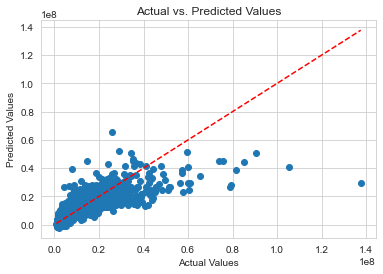

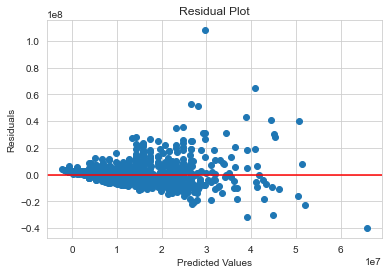

In [40]:
plot_predicted_v_actual(y_train, linear_pred)
plot_residuals(y_train, linear_pred)


The residual plot informs us that the residual (difference between the predicted and actual value) increases as the predicted values increases in size. This is a symptom of heteroscedasticity (https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/). Hence, we will employ regression techinques to reduce this. 


In [41]:
from sklearn.metrics import r2_score, mean_squared_error
#calculating the R-squared score 
r_squared_lin = r2_score(y_train, linear_pred)
print("linear R^2 score: ", r_squared_lin)

#calculating the mean squared error(MSE)
mse_lin = mean_squared_error(y_train, linear_pred)
print("linear MSE score: ", mse_lin) #whoops we were printing out the r2 score again here

#https://www.geeksforgeeks.org/cross-validation-machine-learning/
from sklearn.model_selection import cross_val_score, KFold
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results_lin = cross_val_score(LinearRegression(), X_train, y_train, cv=kf)
print(f'Cross-Validation Results (Accuracy): {cross_val_results_lin}')
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_results_lin.mean(), cross_val_results_lin.std()))



linear R^2 score:  0.5605274033764223
linear MSE score:  60013795240291.54
Cross-Validation Results (Accuracy): [0.64996453 0.57565537 0.41547032 0.67342388 0.5953813  0.59070962
 0.50424602 0.53634601 0.55372164 0.51100335]
0.56 accuracy with a standard deviation of 0.07


### Testing for the present of multicolinearity within features to reduce dimensionality within X 

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# calculating VIF for each feature 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                          for i in range(len(X_train.columns))] 


In [43]:
vif_data

,feature,VIF
0,weekly_views,7.223859
1,cumulative_weeks_in_top_10,2.707092
2,runtime,2.692103
3,number_of_seasons,1.090190
4,is_staggered_launch,1.025651
5,language_English,2.756723
6,type_Films,3.129528
7,available_globally_No,1.427345


It is clear that multiple features have high multicolinearity hence we will employ PCA to tackle this issue

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale data before applying PCA
scaling=StandardScaler()

# Use fit and transform method 
scaling.fit(X_train)
Scaled_data=scaling.transform(X_train)
 
# Set the n_components=3
principal=PCA(n_components=8)
principal.fit(Scaled_data)
x_train_after_pca =principal.transform(Scaled_data)

# Check the dimensions of data after PCA
print(x_train_after_pca.shape)

# check how much variance is explained by each principal component
print(principal.explained_variance_ratio_)




(1492, 8)
[0.25870354 0.17952375 0.14531329 0.12951402 0.11447901 0.1059866
 0.04525802 0.02122176]


### Retraining after the PCA reduced dimensionality to 9 features (since most of the information can be captured by 9 features instead of 11)

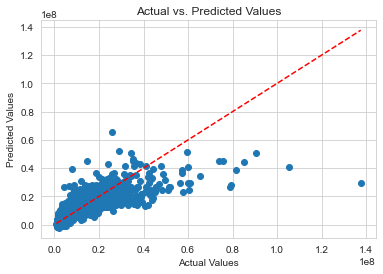

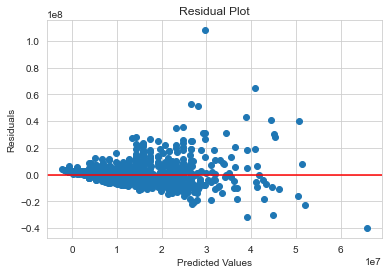

In [45]:
linear_model_after_pca = LinearRegression(fit_intercept=True).fit(x_train_after_pca,y_train)
linear_pred_after_pca = linear_model_after_pca.predict(x_train_after_pca)

plot_predicted_v_actual(y_train, linear_pred_after_pca)
plot_residuals(y_train, linear_pred_after_pca)

### Now we proceed onto generalization 

In [46]:
(x_train_after_pca == 0).sum().sum()
# this means that the modified dataset is not sparse 

0

In [47]:

print(x_train_after_pca.shape)

(1492, 8)


In [48]:
vif_data_pca = pd.DataFrame() 
vif_data_pca["VIF"] = [variance_inflation_factor(x_train_after_pca, i) 
                          for i in range(len(x_train_after_pca[0]))] 

In [49]:
vif_data_pca

,VIF
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0


In [50]:
#calculating the R-squared score 
r_squared_lin = r2_score(y_train, linear_pred_after_pca)
print("linear R^2 score: ", r_squared_lin)

#calculating the mean squared error(MSE)
mse_lin = mean_squared_error(y_train, linear_pred_after_pca)
print("linear MSE score: ", mse_lin)

#https://www.geeksforgeeks.org/cross-validation-machine-learning/
num_folds_pca = 500
kf_pca = KFold(n_splits = num_folds_pca, shuffle = True, random_state = 42)
cross_val_results_lin_after_pca = cross_val_score(LinearRegression(), x_train_after_pca, y_train, cv = kf_pca)
print(f'PCA Cross-Validation Results (Accuracy): {cross_val_results_lin_after_pca}')
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_results_lin_after_pca.mean(), cross_val_results_lin_after_pca.std()))

linear R^2 score:  0.5605274033764223
linear MSE score:  60013795240291.54
PCA Cross-Validation Results (Accuracy): [-2.76673085e-01  6.47073396e-01  1.05176602e-01  7.13968600e-01
  8.73977120e-01 -5.23908386e+00 -1.53136284e+00 -8.61018963e-02
  4.39122432e-02 -5.74623788e+00 -2.85324861e+00  8.71093093e-01
  2.27173027e-01 -2.22582534e+00  9.00848252e-01  4.33307335e-01
 -7.71782674e+00  9.48740302e-01 -2.12939302e+00  3.31048604e-01
  3.72322620e-01  2.95120948e-01 -6.17353065e-01  7.57622590e-01
  6.60317745e-01  6.26523186e-02  1.64983528e-01  8.45935426e-01
 -7.73815271e+00  8.61468837e-01  8.96424290e-01  7.30007898e-01
 -4.90195931e+01 -1.13170756e+01 -4.19283836e+01  6.72404484e-01
  5.56134518e-01 -2.59373286e+00  7.43702243e-01  9.55561416e-01
 -1.72795715e+00 -3.18128705e-01 -5.09123538e-01  3.05110456e-01
  9.86596286e-01  7.67088833e-02  6.35849328e-01 -1.80493979e-01
  1.21163396e-01  2.93500305e-01  6.90317793e-01  5.37230544e-01
  5.68830193e-01  4.02355521e-01 -2.100

## the accuracy did not improve much, we will proceed with generalization methods we will generalize data obtained before and after PCA to do a comparison to see if PCA makes a true difference 

In [57]:
from sklearn.metrics import mean_absolute_error 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sys 
#doing plain ridge 
a = 0.65

#standarising the pre PCA values 
netflix_std = StandardScaler().fit_transform(netflix)
# netflix_std = pd.DataFrame(netflix_std)
# netflix_std.head()
X_std = netflix_std[:, :8]
y_std = netflix_std[:, 8]

X_train_std,X_test_std, y_train_std, y_test_std = train_test_split(X_std, y_std, test_size=0.2, random_state=42)

ridge_prePCA =  Ridge(fit_intercept=True, alpha=a).fit(X_train_std, y_train_std).predict(X_test_std)
#ridge_postPCA = Ridge(fit_intercept=True, alpha=a).fit(x_train_after_pca, y_train_after_pca).predict(x_test_after_pca)
mse_ridge_pre = mean_squared_error(y_test_std, ridge_prePCA)
#mse_ridge_post = mean_squared_error(y_test_after_pca, ridge_postPCA)

print("pre :",mse_ridge_pre )
#print("post :",mse_ridge_post )

pre : 0.32964302433595427


In [58]:

X_beforePCA = X_train.copy()
X_afterPCA = x_train_after_pca.copy()
y_to_test = y_test.copy()

alpha_values = [0, 0.0001, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 500, 1000]
max_r2_score = sys.float_info.min
method = ""
alpha_min = 0

#Attempting Ridge for data before PCA
for a in alpha_values:
  print("ALPHA VALUE IS :", a)
  # Create a pipeline with StandardScaler and Ridge regression
  ridge_pipeline = Pipeline([
      ('scaler', StandardScaler()),
      ('ridge', Ridge(fit_intercept=True, alpha=a))  # You can adjust the alpha parameter as needed
  ])
  lin = ridge_pipeline.fit(X_beforePCA ,y_train)

  yhat = lin.predict(X_test)
  mse_lin = mean_squared_error(y_to_test, yhat)
  print("Ridge MSE: ", mse_lin)
  r_squared_lin = r2_score(y_to_test, yhat)
  print("linear R^2 score: ", r_squared_lin)

  if r_squared_lin > max_r2_score:
    method = "ridge"
    alpha_min = a
    max_r2_score = r_squared_lin

  yhat_lasso = Lasso(fit_intercept=True, alpha = a).fit(X_beforePCA, y_train).predict(X_test)
  lasso_lin = mean_squared_error(y_to_test, yhat_lasso)
  r_squared_lasso = r2_score(y_to_test, yhat_lasso)
  print("Lasso MSE: ", lasso_lin)

  if r_squared_lasso > max_r2_score:
    method = "lasso"
    alpha_min = a
    max_r2_score = r_squared_lasso

print("Consolidated values: ")
print("METHOD :", method)
print("ALPHA :",alpha_min)
print("MIN ERROR :", max_r2_score)


ALPHA VALUE IS : 0
Ridge MSE:  43944701768027.1
linear R^2 score:  0.6346545948234226
Lasso MSE:  43944701768027.07
ALPHA VALUE IS : 0.0001
Ridge MSE:  43944701806903.445
linear R^2 score:  0.6346545945002142
Lasso MSE:  43944701769149.805
ALPHA VALUE IS : 0.1
Ridge MSE:  43944740761578.96
linear R^2 score:  0.6346542706406557
Lasso MSE:  43944702890759.34
ALPHA VALUE IS : 0.5
Ridge MSE:  43944899078589.09
linear R^2 score:  0.6346529544321053
Lasso MSE:  43944707381816.43
ALPHA VALUE IS : 1
Ridge MSE:  43945102229419.086
linear R^2 score:  0.6346512654862413


/var/folders/b7/8z5_rxhj3j7brh5_gncbm6w00000gn/T/ipykernel_77825/41643116.py:31: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  yhat_lasso = Lasso(fit_intercept=True, alpha = a).fit(X_beforePCA, y_train).predict(X_test)
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.477e+16, tolerance: 2.037e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

Lasso MSE:  43944712995929.12
ALPHA VALUE IS : 5
Ridge MSE:  43946934457596.164
linear R^2 score:  0.6346360327933616
Lasso MSE:  43944757920291.43
ALPHA VALUE IS : 10
Ridge MSE:  43949728052066.8
linear R^2 score:  0.6346128075383772
Lasso MSE:  43944814104545.266
ALPHA VALUE IS : 20
Ridge MSE:  43956910458191.45
linear R^2 score:  0.6345530947864371
Lasso MSE:  43944926568830.23
ALPHA VALUE IS : 50
Ridge MSE:  43990098291792.01
linear R^2 score:  0.6342771793284661
Lasso MSE:  43945264728550.19
ALPHA VALUE IS : 100
Ridge MSE:  44079985846290.08
linear R^2 score:  0.6335298763841478
Lasso MSE:  43945830883744.06
ALPHA VALUE IS : 500
Ridge MSE:  45989881428678.86
linear R^2 score:  0.6176514758644187
Lasso MSE:  43950475138470.336
ALPHA VALUE IS : 1000
Ridge MSE:  49986823575086.11
linear R^2 score:  0.5844218852836278
Lasso MSE:  43956567986815.45
Consolidated values: 
METHOD : lasso
ALPHA : 0
MIN ERROR : 0.6346545948234228


## Generalization does not seem to improve the accuracy of prediction

In [59]:
alpha = .1 # regularization parameter

lin = Ridge(alpha=0).fit(X,y)
yhat = lin.predict(X)
yhat

array([ 856676.32211814, 5102365.68046701, 5274804.56577623, ...,
       3384047.47561716, 2410521.39894552, 2410521.39894552])


# We should ask about the fix to heteroscedasticity faced - doesnt seem too simple??

/Applications/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


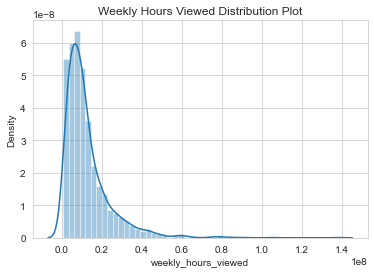

In [60]:
# Data distribution
plt.title('Weekly Hours Viewed Distribution Plot')
sns.distplot(netflix['weekly_hours_viewed'])
plt.show()

### Polynomial Model

In [61]:
#y = (netflix["weekly_hours_viewed"]).values
#X = (netflix.copy().drop(['weekly_hours_viewed'], axis=1)).values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
 
pr = PolynomialFeatures(degree = 4)
X_poly = pr.fit_transform(X_train)
lr_2 = LinearRegression()
lr_2.fit(X_poly, y_train)
#Predict results
y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
#lr_2.fit(pr.fit_transform(X_test), y_test)
y_test_pred_poly = lr_2.predict(pr.fit_transform(X_test))


In [63]:
def poly_plot_predicted_v_actual(y_train, y_pred):
  #helps us understand the relationship between the predicted and the actual values
  plt.scatter(y_train, y_pred)
  plt.plot(y_train, lr_2.predict(pr.fit_transform(X_train)), color = 'firebrick', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')
  plt.show()

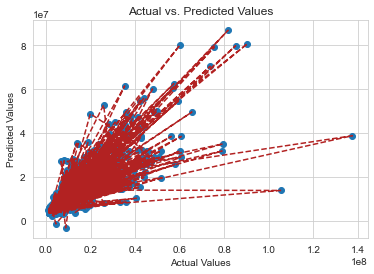

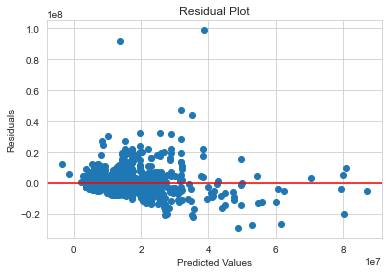

In [64]:
poly_plot_predicted_v_actual(y_train, y_pred_poly)
plot_residuals(y_train, y_pred_poly)

In [65]:
# This function just computes the mean squared error
def MSE(y, pred):
    return np.square(np.subtract(y,pred)).mean()

In [66]:
mean_squared_error(y_train, linear_pred_after_pca.flatten())

60013795240291.54

In [67]:
# linear train and test MSE
linear_test_pred = linear_model.predict(X_test)

linear_train_MSE = MSE(y_train, linear_pred.flatten())
linear_test_MSE = MSE(y_test, linear_test_pred.flatten())
print("Linear Train MSE\t", str(linear_train_MSE))
print("Linear Test MSE\t", str(linear_test_MSE))
linear_train_PCA_MSE = MSE(y_train, linear_pred_after_pca.flatten())
print("Linear Train with PCA MSE\t", str(linear_train_PCA_MSE))

Linear Train MSE	 60013795240291.484
Linear Test MSE	 43944701768027.81
Linear Train with PCA MSE	 60013795240291.56


In [68]:
# polynomial train and test MSE at degree 4
poly_train_MSE = MSE(y_train, y_pred_poly.flatten())
print("Polynomial Train MSE\t", str(poly_train_MSE))
poly_test_MSE = MSE(y_test, y_test_pred_poly.flatten())
print("Polynomial Train MSE\t", str(poly_test_MSE))

Polynomial Train MSE	 49247188020076.555
Polynomial Train MSE	 2017402895298193.2


In [69]:
# compare train and test MSE for polynomials of degrees 1-7
for i in range(7):
  pr = PolynomialFeatures(degree = i+1)
  X_poly = pr.fit_transform(X_train)
  lr_2 = LinearRegression()
  lr_2.fit(X_poly, y_train)
  #Predict results
  y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
  y_test_pred_poly = lr_2.predict(pr.fit_transform(X_test))
  
  poly_train_MSE = MSE(y_train, y_pred_poly.flatten())
  print(("Polynomial Train MSE" + " at degree " + str(i+1) + "\t"), str(poly_train_MSE))
  poly_test_MSE = MSE(y_test, y_test_pred_poly.flatten())
  print(("Polynomial Test MSE" + " at degree " + str(i+1) + "\t"), str(poly_test_MSE))


Polynomial Train MSE at degree 1	 60013795240291.58
Polynomial Test MSE at degree 1	 43944701768027.11
Polynomial Train MSE at degree 2	 51989716159646.945
Polynomial Test MSE at degree 2	 41617330588266.08
Polynomial Train MSE at degree 3	 42791707842484.31
Polynomial Test MSE at degree 3	 123437219617701.81
Polynomial Train MSE at degree 4	 49247188020076.555
Polynomial Test MSE at degree 4	 2017402895298193.2
Polynomial Train MSE at degree 5	 82596157503156.39
Polynomial Test MSE at degree 5	 1.6769532530556264e+16
Polynomial Train MSE at degree 6	 95406211829916.9
Polynomial Test MSE at degree 6	 1809204227113247.0
Polynomial Train MSE at degree 7	 107979052483223.19
Polynomial Test MSE at degree 7	 1608009734787952.2


In [70]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [71]:
from numpy.random import rand, randn
def generate_data(n, w):
    X = randn(n,len(w))
    y = X@w
    return X, y
def generate_noisy_data(n, w):
    X = randn(n,len(w))
    y = X@w + .1*randn(n)
    return X, y

In [72]:
#y = (netflix["weekly_hours_viewed"]).values
#X = (netflix.copy().drop(['weekly_hours_viewed'], axis=1)).values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alpha_ridge=.1
alpha_lasso=.1

w_randn = randn(30)
w_ridge = Ridge(alpha = alpha_ridge).fit(X,y).coef_
w_lasso = Lasso(alpha = alpha_lasso).fit(X,y).coef_
w_nonneg = LinearRegression(positive=True).fit(X,y).coef_
w_sparse = w_randn*(abs(w_randn) > 1)


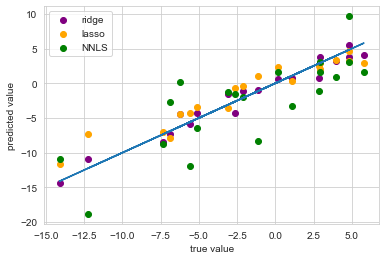

In [73]:
#w_randn
X,y = generate_data(30, w_randn)
Xtest,ytest = generate_data(20,w_randn)

yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest)
plt.scatter(ytest, yhat_ridge, label="ridge", color="purple")
plt.scatter(ytest, yhat_lasso, label="lasso", color="orange")
plt.scatter(ytest, yhat_nonneg, label="NNLS", color="green")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

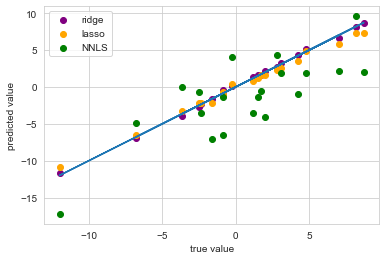

In [74]:
#w_sparse
X,y = generate_data(30, w_sparse)
Xtest,ytest = generate_data(20,w_sparse)

yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest)
plt.scatter(ytest, yhat_ridge, label="ridge", color="purple")
plt.scatter(ytest, yhat_lasso, label="lasso", color="orange")
plt.scatter(ytest, yhat_nonneg, label="NNLS", color="green")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

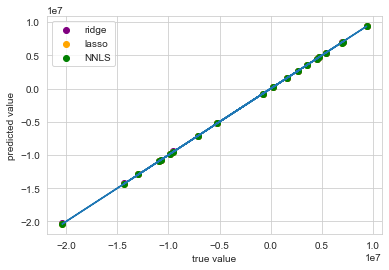

In [75]:
#w_nonneg
#w_nonneg = LinearRegression(positive=True).fit(X,y).coef_
X,y = generate_data(30, w_nonneg)
Xtest,ytest = generate_data(20,w_nonneg)

yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest)
plt.scatter(ytest, yhat_ridge, label="ridge", color="purple")
plt.scatter(ytest, yhat_lasso, label="lasso", color="orange")
plt.scatter(ytest, yhat_nonneg, label="NNLS", color="green")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

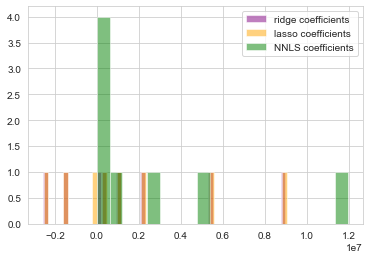

In [76]:
plt.hist(w_ridge, label="ridge coefficients", bins=50, alpha=.5, color="purple")
plt.hist(w_lasso, label="lasso coefficients", bins=50, alpha=.5, color="orange")
plt.hist(w_nonneg, label="NNLS coefficients", bins=20, alpha=.5, color="green")
plt.legend()

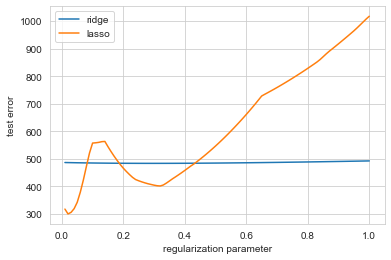

In [77]:
# cross validate over regularization parameter alpha
np.random.seed(6)

w = randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

ridge_error = []
lasso_error = []
alphas = np.linspace(.01,1,100)
for alpha in alphas:
    yhat_ridge = Ridge(alpha = alpha).fit(X,y).predict(Xtest)
    ridge_error.append(sum((ytest - yhat_ridge)**2))
    yhat_lasso = Lasso(alpha = alpha).fit(X,y).predict(Xtest)
    lasso_error.append(sum((ytest - yhat_lasso)**2))
plt.plot(alphas, ridge_error, label="ridge")
plt.plot(alphas, lasso_error, label="lasso")
plt.ylabel("test error")
plt.xlabel("regularization parameter")
plt.legend()

### Decision Tree Regression

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree

In [79]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=12)
cross_val_scores = cross_val_score(regressor, X_train, y_train, cv=10)
average_score = cross_val_scores.mean()
print(f"Average Cross Validation Score for 10 folds: {average_score:.4f}")

regressor.fit(X_train, y_train)
test_score = regressor.score(X_test, y_test)
train_score = regressor.score(X_train, y_train)
print(f"Accuracy on Train Set: {train_score:.4f}")
print(f"Accuracy on Test Set: {test_score:.4f}")


Average Cross Validation Score for 10 folds: 0.4863
Accuracy on Train Set: 0.8883
Accuracy on Test Set: 0.3827


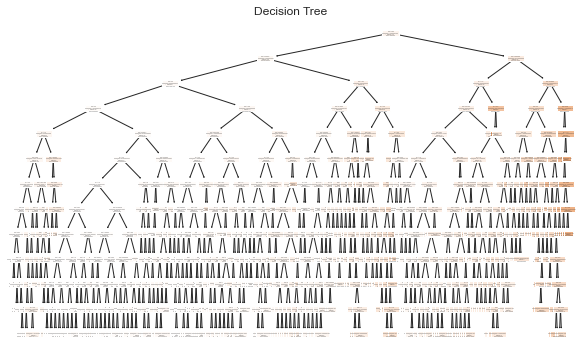

In [80]:
regressor.fit(X_train,y_train)
plt.figure(figsize=(10, 6))
plot_tree(regressor, filled=True)
plt.title("Decision Tree")
plt.show()

In [81]:
# Score based on squared error
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)
tree_train_MSE = mean_squared_error(y_train, y_pred_train)
tree_test_MSE = mean_squared_error(y_test, y_pred_test)
print("MSE on training set:", tree_train_MSE)
print("MSE on test set:", tree_test_MSE)

MSE on training set: 15253649479451.604
MSE on test set: 74251597888736.12


We can see that both the accuracy and the test set are high, so we can utilize ensemble methods to try and reduce the bias. We will use Decision Tree Boosting technique

In [82]:
from sklearn.ensemble import GradientBoostingRegressor # uses squared loss, default learning rate 0.1

In [83]:
# First, grid search to find the best hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7, 10]
}

boosted_reg = GradientBoostingRegressor(random_state=0)

grid_search = GridSearchCV(estimator=boosted_reg, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

boosted = grid_search.best_estimator_

best_boosted_reg_test_MSE = mean_squared_error(y_test, boosted.predict(X_test))
print("Test set MSE for best boosted regression model:", best_boosted_reg_test_MSE)


In [ ]:
# boosted = GradientBoostingRegressor(random_state=0, max_depth=12, n_estimators=10000)
# boosted.fit(X_train, y_train)

cross_val_scores_gb = cross_val_score(boosted, X_train, y_train, cv=10)
average_score_gb = cross_val_scores_gb.mean()
print(f"Average Cross Validation Score for 10 folds in Boosted Model: {average_score_gb:.4f}")

Average Cross Validation Score for 10 folds in Boosted Model: 0.6376


In [ ]:
test_score_gb = boosted.score(X_test, y_test)
train_score_gb = boosted.score(X_train, y_train)
print(f"Accuracy on Train Set: {train_score_gb:.4f}")
print(f"Accuracy on Test Set: {test_score_gb:.4f}")

Accuracy on Train Set: 0.7940
Accuracy on Test Set: 0.6493


In [ ]:
y_pred_train_boosted = boosted.predict(X_train)
y_pred_test_boosted = boosted.predict(X_test)

boosted_train_MSE= mean_squared_error(y_train, y_pred_train)
boosted_test_MSE = mean_squared_error(y_test, y_pred_test)

print("MSE on training set:", boosted_train_MSE)
print("MSE on test set:", boosted_test_MSE)

MSE on training set: 15253649479451.604
MSE on test set: 74251597888736.12


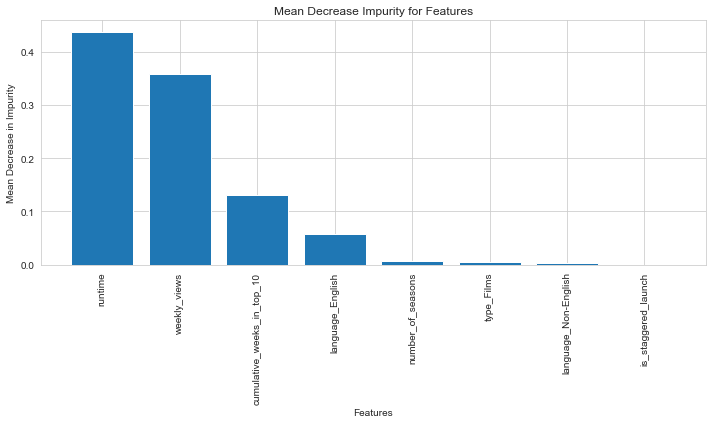

In [ ]:
feature_names=['weekly_views','cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons', 'is_staggered_launch', 
'language_English', 'language_Non-English', 'type_Films', 'type_TV', 'available_globally_No', 'available_globally_Yes']
feature_importances = boosted.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_features = np.array(feature_names)[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), sorted_feature_importances, align='center')
plt.xticks(range(len(feature_importances)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Mean Decrease in Impurity')
plt.title('Mean Decrease Impurity for Features')
plt.tight_layout()
plt.show()

### Comparing Results from all 3 models

In [ ]:
print("Training set MSE:")
print("Linear Regression:", linear_train_MSE)
print("Polynomial Regression:", poly_train_MSE)
print("Regular Decision Tree Regressor:", tree_train_MSE)
print("Boosted Regression:", boosted_train_MSE)

print("\nTest set MSE:")
print("Linear Regression:", linear_test_MSE)
print("Polynomial Regression:", poly_test_MSE)
print("Regular Decision Tree Regressor:", tree_test_MSE)
print("Boosted Regression:", boosted_test_MSE)


best_model_train = min(linear_train_MSE, poly_train_MSE, boosted_train_MSE, boosted_train_MSE)
best_model_test = min(linear_test_MSE, poly_test_MSE,tree_test_MSE, boosted_test_MSE)

if best_model_train == linear_train_MSE:
    print("\nThe best model for training set is Linear Regression.")
elif best_model_train == poly_train_MSE:
    print("\nThe best model for training set is Polynomial Regression.")
elif best_model_train==boosted_train_MSE:
    print("The best model for train set is Regular Decision Tree Regressor.")
else:
    print("\nThe best model for training set is Boosted Regression.")

if best_model_test == linear_test_MSE:
    print("The best model for test set is Linear Regression.")
elif best_model_test == poly_test_MSE:
    print("The best model for test set is Polynomial Regression.")
elif best_model_test==boosted_test_MSE:
    print("The best model for test set is Regular Decision Tree Regressor.")
else:
    print("The best model for test set is Boosted Regression.")


Training set MSE:
Linear Regression: 60013795240291.484
Polynomial Regression: 107979052483223.19
Regular Decision Tree Regressor: 15253649479451.604
Boosted Regression: 15253649479451.604

Test set MSE:
Linear Regression: 43944701768027.81
Polynomial Regression: 1608009734787952.2
Regular Decision Tree Regressor: 74251597888736.12
Boosted Regression: 74251597888736.12
The best model for train set is Regular Decision Tree Regressor.
The best model for test set is Linear Regression.
